In [24]:
import pandas as pd
import json
from pathlib import Path
import ast
import gzip

# Essential imports and settings for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown
import warnings
warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', 50)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', None)  # or use a large number like 1000

# Matplotlib settings
%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'

# Development helpers
%load_ext autoreload
%autoreload 2
%xmode Verbose

# Progress bars
# from tqdm.notebook import tqdm
# tqdm.pandas()

print("✅ Jupyter setup complete!")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Exception reporting mode: Verbose
✅ Jupyter setup complete!


In [187]:
# first, let's read all the files
from json import JSONDecodeError


def parse_and_iterate(files):
    
    for file in files:
        if file.suffix == ".gz":
            opener = gzip.open(file, "rt")
        else:
            opener = open(file, "rt")
        with opener as f:
            content = f.read()

        # try to parse it as a json file first
        try:
            record = json.loads(content)

            if isinstance(record, list):
                for rec in record:
                        yield rec
            elif isinstance(record, dict):
                yield record
            else:
                yield {"__value__": rec}
            continue
        except JSONDecodeError:
            pass

        # try to parse as a jsonl file
        for line in content.splitlines():
            if line.strip():
                try:
                    record = json.loads(line)
                    if isinstance(record, list):
                        for rec in record:
                            yield rec
                    elif isinstance(record, dict):
                        yield record
                    else:
                        yield {"__value__": rec}
                except JSONDecodeError:
                    print("invalid json and jsonl", file)
                    continue

    
    
files = list(Path("./").glob("codepro*json*"))
recs = [rec for rec in parse_and_iterate(files)]
rows = len(recs)

In [188]:
df = pd.DataFrame(recs)
df.head(), df.lang.value_counts()

(       id lang       source  \
 0  k675_0   py  gen_example   
 1  k225_0   py   doc_sample   
 2  k225_1   py       repo_B   
 3  k483_0   js       repo_B   
 4  k483_1   py  gen_example   
 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              code  
 0                                                                                                                                                                                                                                                               

In [189]:
# 1) **Python**: parse rate (`py_parse_rate`), total function defs (`py_total_funcs`), and count of branch nodes (`py_branch_nodes` ~ If/For/While/Try).

py_rows = df[df['lang'] == "py"]
py_rows

def parse_rows(code):
    try:
        return ast.parse(code.encode().decode('unicode_escape'))
    except SyntaxError:
        return None


py_rows['parsed_code'] = py_rows.code.apply(parse_rows)
py_parse_rate = py_rows['parsed_code'].notna().sum() / len(py_rows)
py_parse_rate

np.float64(0.9084249084249084)

In [190]:
# 1) **Python**: parse rate (`py_parse_rate`), total function defs (`py_total_funcs`), and count of branch nodes (`py_branch_nodes` ~ If/For/While/Try).

def walk_and_check_function_def(node):
    f_defs = 0
    if not node:
        return 0
    for n in ast.walk(node):
        if isinstance(n, ast.FunctionDef):
            f_defs += 1
    return f_defs

py_total_funcs = py_rows['parsed_code'].apply(walk_and_check_function_def).sum()
py_total_funcs

np.int64(1589)

In [198]:
# 1) **Python**: parse rate (`py_parse_rate`), total function defs (`py_total_funcs`), and count of branch nodes (`py_branch_nodes` ~ If/For/While/Try).

def walk_and_check_function_def(node):
    if not node:
        return 0
    f_branch = 0
    for n in ast.walk(node):
        if isinstance(n, ast.While) or isinstance(n, ast.For) or isinstance(n, ast.If) or isinstance(n, ast.Try):
            f_branch += 1
    return f_branch

py_rows['n_branches'] = py_rows.parsed_code.apply(walk_and_check_function_def)
get_branch_n = py_rows['n_branches'].sum()
get_branch_n

np.int64(2256)

In [215]:
# 2) **Danger patterns**: counts for `["eval","exec","open(","subprocess","pickle.loads","yaml.load("]` across all code.
# danger_patterns = ["eval", "exec", "open(", "subprocess", "pickle.loads", "yaml.load("]


danger_counts = {
    "eval": 0,
    "exec": 0,
    "open(": 0,
    "subprocess": 0,
    "pickle.loads": 0,
    "yaml.load(": 0
}
def count_dangerous_patterns(row):
    for pattern in danger_counts.keys():
        danger_counts[pattern] += row.count(pattern)

py_rows.code.apply(count_dangerous_patterns)
danger_counts

{'eval': 79,
 'exec': 0,
 'open(': 0,
 'subprocess': 0,
 'pickle.loads': 256,
 'yaml.load(': 251}

In [193]:
# 3) **JS**: `js_eval_count` (rows with `eval(`) and `long_lines_over_200` across all langs.
js_rows = df[df['lang'] == 'js']
import re
pat = "eval" + re.escape('(')
js_eval_count = js_rows.code.str.count(pat).sum()
js_eval_count

np.int64(57)

In [209]:
# long_lines_over_200

def count_lines(text):
    cnt = 0
    for line in text.encode().decode("unicode_escape").splitlines():
        if len(line) > 200:
            cnt += 1
    return cnt
    # return text.encode().decode("unicode_escape").count("\n")

df["n_lines"] = df.code.apply(count_lines)
long_lines_over_200 = df["n_lines"].sum()
long_lines_over_200

np.int64(166)

In [195]:
from collections import Counter
all_calls = []
def walk_calls(node):
    if not node:
        return
    for n in ast.walk(node):
        if isinstance(n, ast.Call):
            if isinstance(n.func, ast.Name):
                all_calls.append(n.func.id)
            else:
                all_calls.append(n.func.value.id)
py_rows.parsed_code.apply(walk_calls)
top_calls = Counter(all_calls).most_common(5)
top_calls = {call:count for call, count in top_calls}
top_calls

{'range': 1031, 'sum': 265, 'print': 264, 'map': 262, 'pickle': 256}

<BarContainer object of 2 artists>

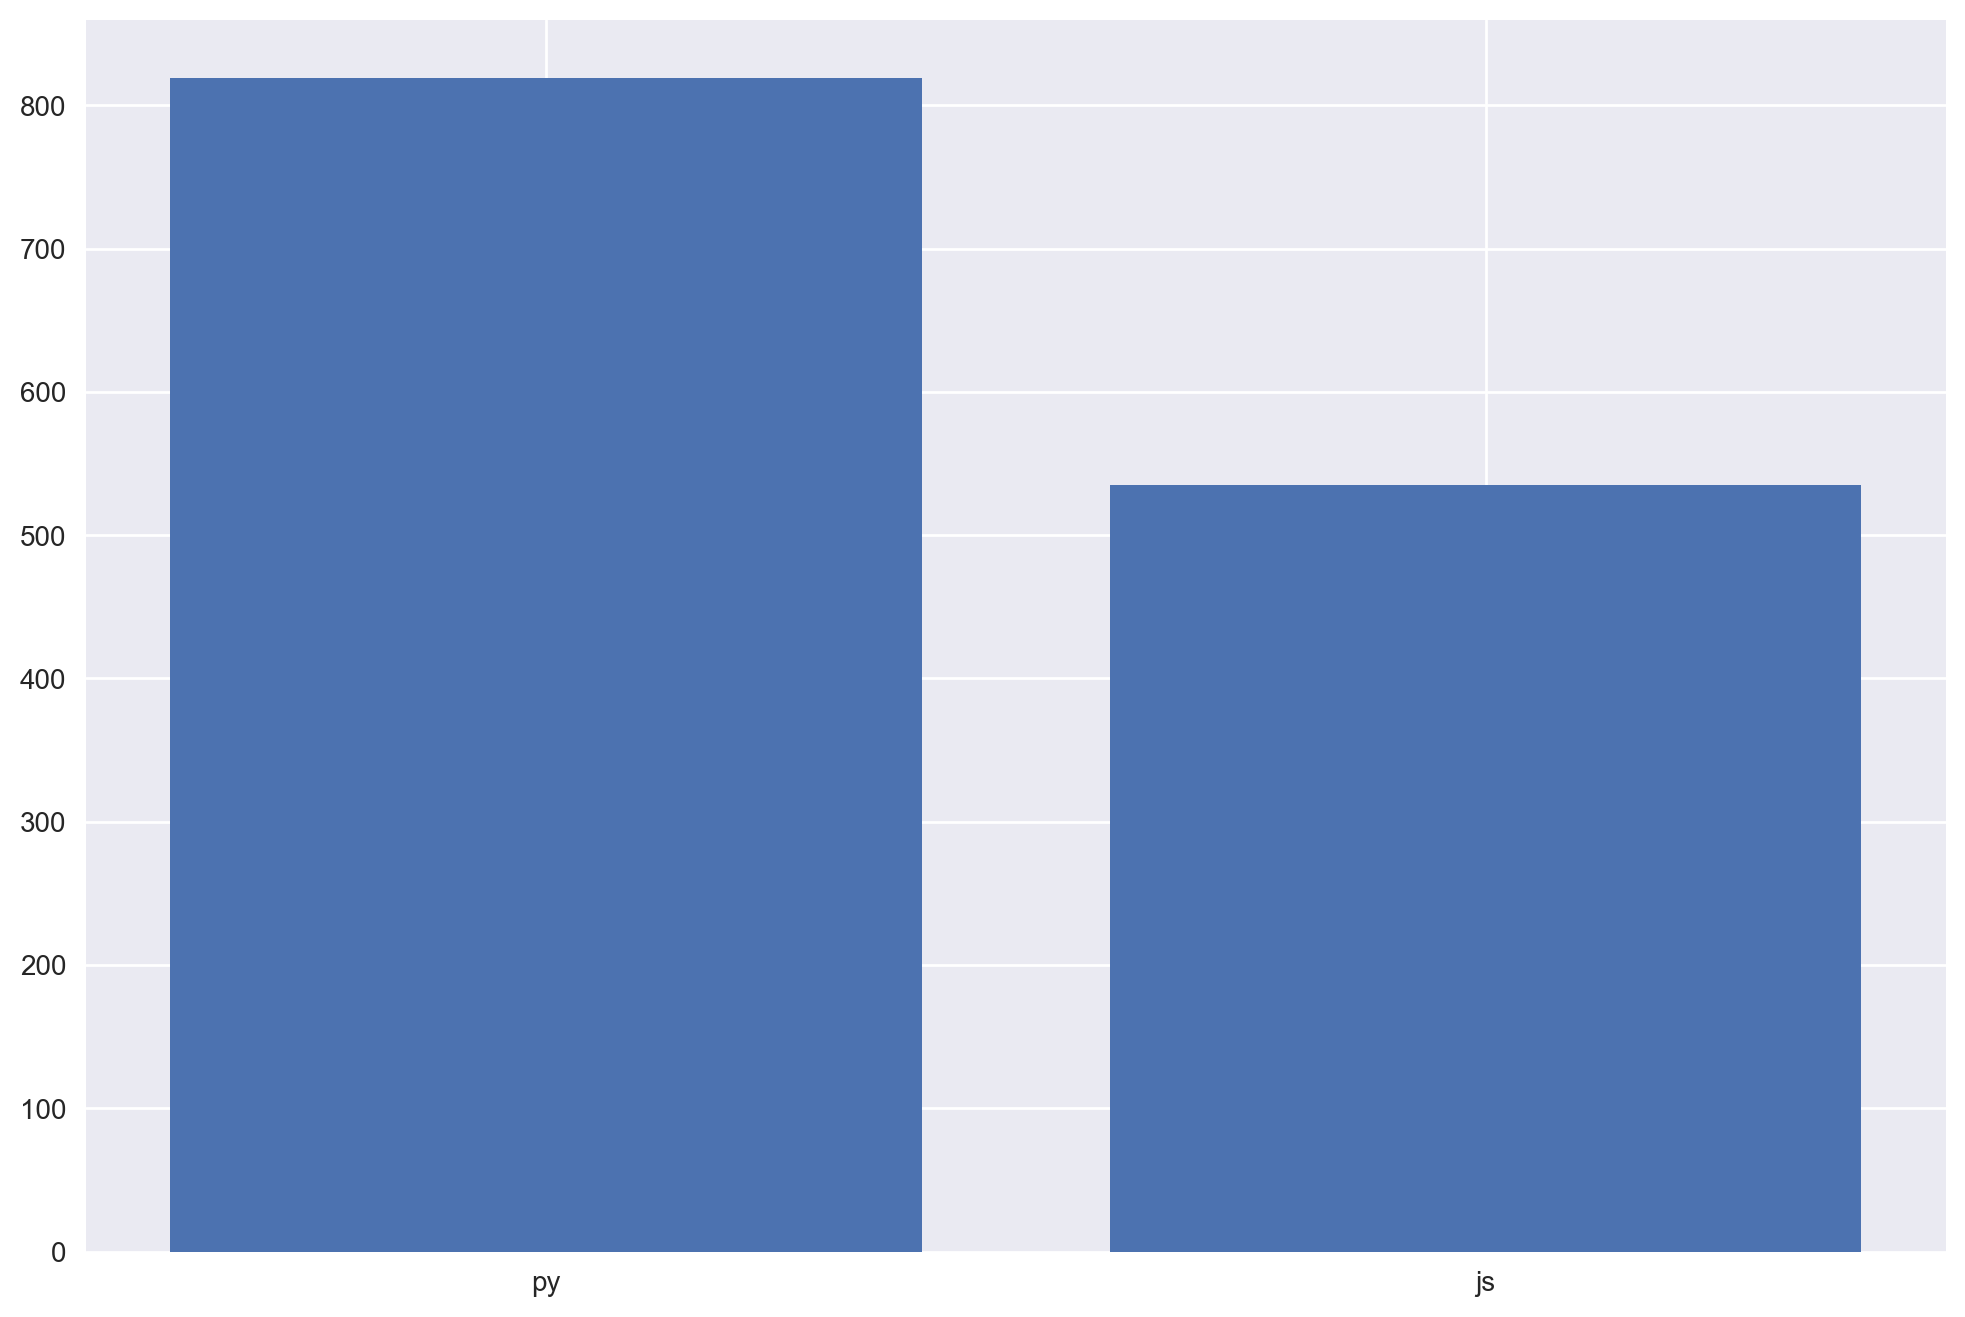

In [196]:
series = df.lang.value_counts()
plt.bar(series.index, series.values)

(array([102., 117., 176., 148.,   0., 133.,  75.,  46.,  16.,   6.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

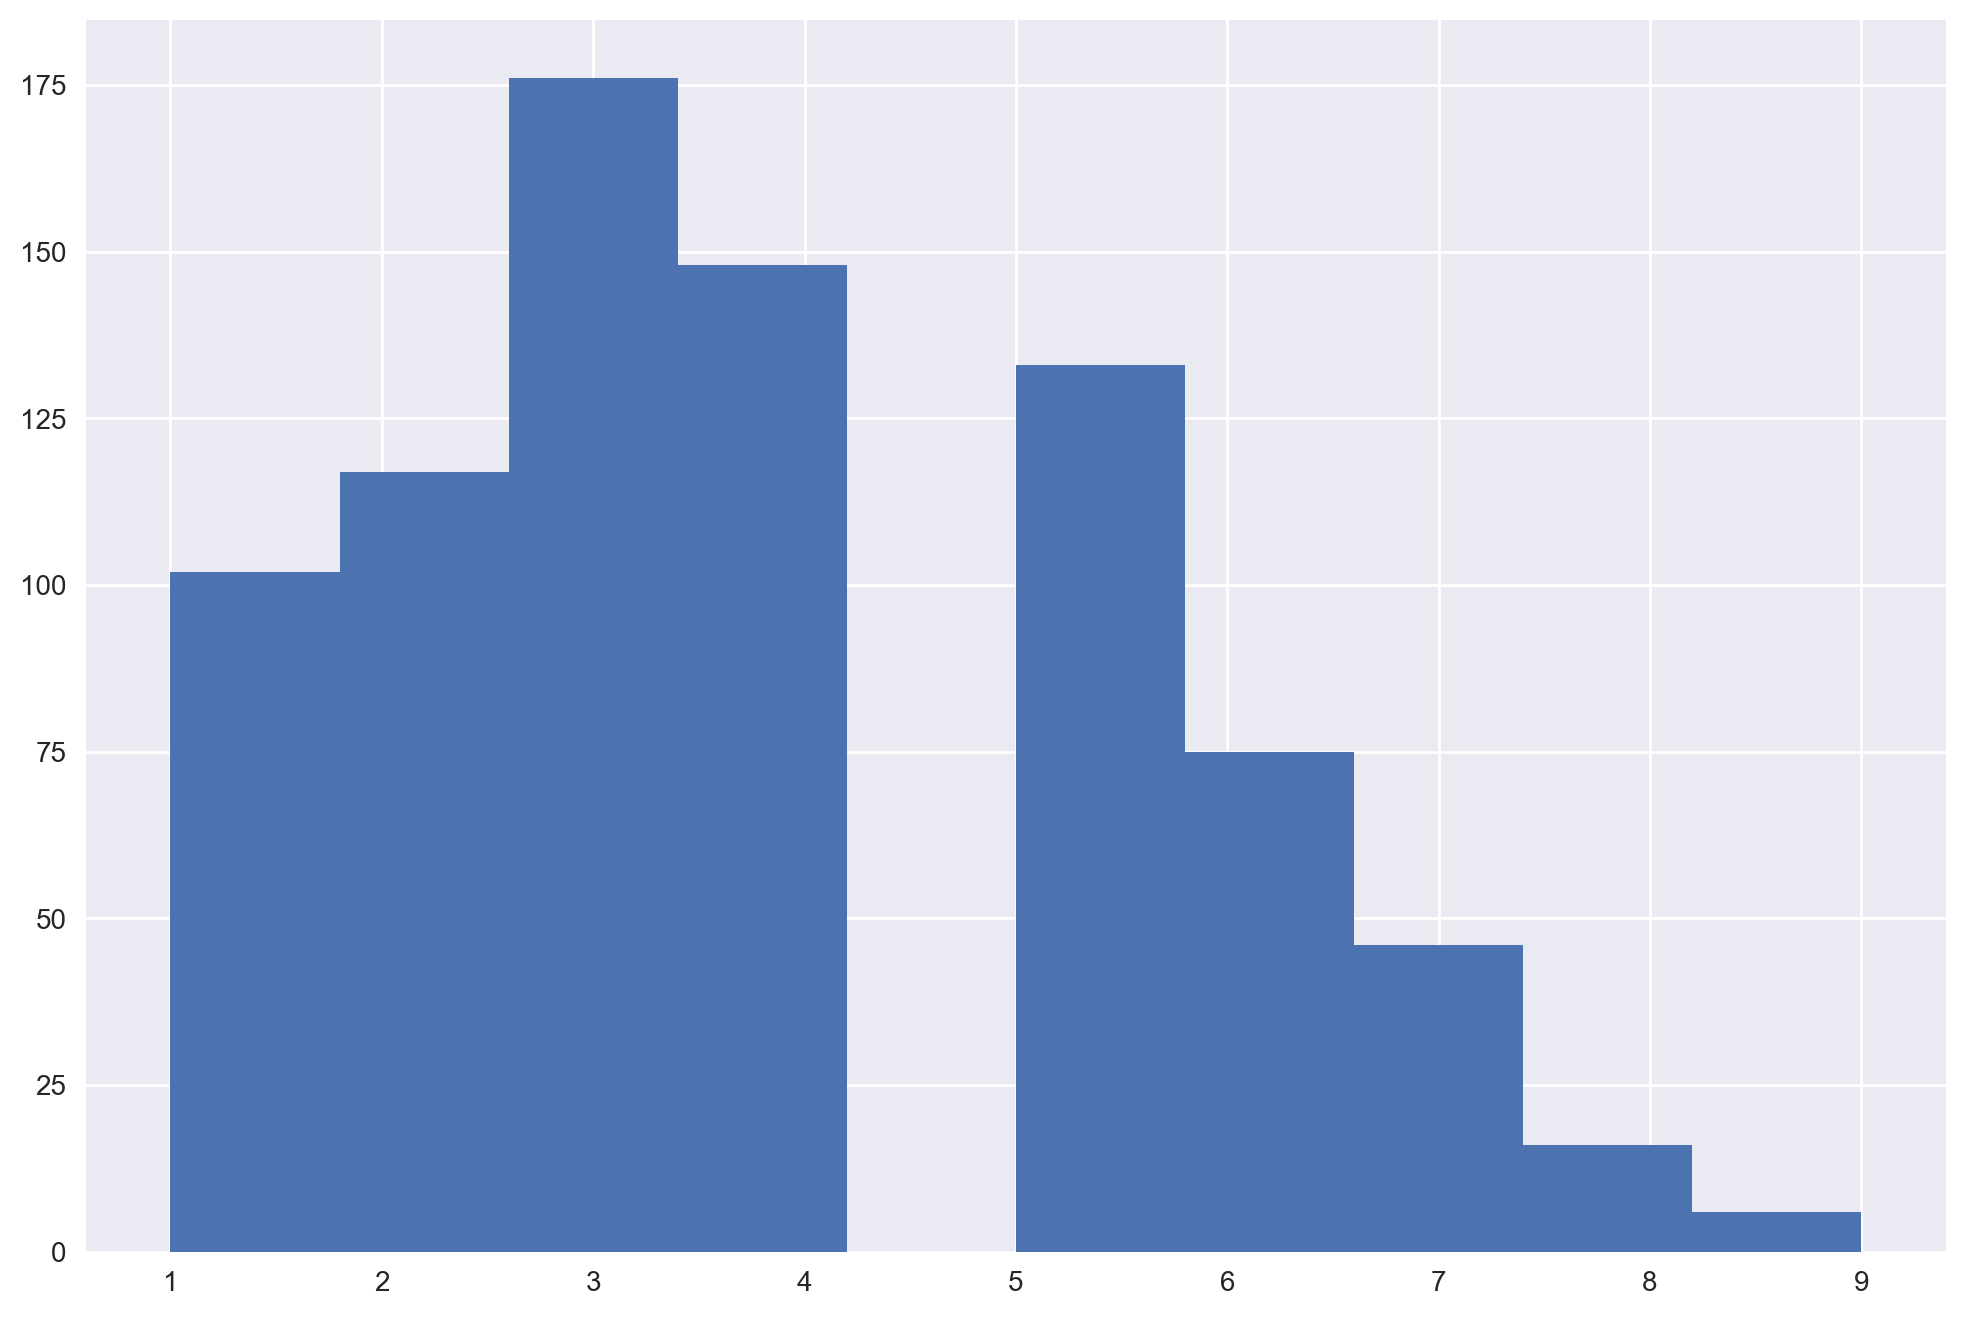

In [206]:
plt.hist(py_rows.n_branches + 1)

In [210]:
py_parse_rate

np.float64(0.9084249084249084)

In [211]:
danger_counts

{'eval': 79, 'exec': 0, 'open(': 0, 'subprocess': 0, 'pickle.loads': 256}

In [212]:
top_calls

{'range': 1031, 'sum': 265, 'print': 264, 'map': 262, 'pickle': 256}

In [213]:
js_eval_count

np.int64(57)

In [214]:
rows

1354